## Battery Assets - optimizaiton

In this notebook, one battery asset charging/discharging duration is optimized and tested against the price thresholds for charging and discharging. The notebook is structured into the following section:

#### Parameters
- **Storage Capacity (MWh):** The total amount of energy the battery can store and discharge.  
- **Power Rating / Nameplate Capacity (MW)**: It is the maximum rate at which battery can deliver or receive power.
e.g.: 100MWh/25MW can deliver 25 MW for 4 hours (100/25). In the UK, most of the battery systems are of 2-hours.
- **Charging efficiency**: Percentange of input energy that successfully stored in a battery. 
- **Discharging efficiency**: The percentage of stored energy that is available when battery is discharged. If a battery has $90\%$ discharge efficiency, then for 100 kWh (SOC), delivered energy would be 90 kWh.
- **Prices:**  Price is the same for charging or discharing energy, in this example, it is considered positive for discharging while negative for charging.
- **Price thresholds:** The minimum price for discharging while the maximum price for charging. 

#### Variables and their bounds
**Charging and discharging**
Both charging and discharging are periods are described by two terminology: state and energy. State is a binary parameter with 0 being 
- State: It is a binary parameter with 1 for the period battery is charged while 0 for the other period. 
- Energy: It is 0 for the period battery is not charged. And, for any other time, it is a non-negative real number. The maximum discharge energy would be equal to power rating time discharge efficiency. The maximum value of charging energy would be power rating/charging efficiency. 

**State of charge**
The state of charge at any time t is a funciton of SOC at t-1 and charged or discharged energy in t duration. 
$$\text{SOC}(t) = \text{SOC}(t-1) + {\text{charge} (t)} - {\text{discharge} (t)}$$
SOC at t = 0 needs to be known in prior to modeling.


### Model constraints:

- **Charging or discharging states:**
In any time period, either battery is charged or discharged or none. Therefore, the sum of these states at any given t will be less than or equal to 1. 
$$\text{charge state}(t) + \text{charge state}(t) <= 1$$
- **Discharging price threshold:** no discharge for price < threshold
- **Charging price threshold:** No charging for price > threshold

SOC, charging energy, and discharging energy bounds are defined during variables declaration. But, their constraints are defined by the rules. 
- **SOC constraint**: SOC logic is defined by using a function for its above stated rule.
- **Charge or discharge energy**: Non-negative values only when their respective states (charge/discharge) is 1. Otherwise, they should be zero.

#### Objective 
- How much energy is to purchase/sell in different time periods subject to maximize profit for charging and discharging energy. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.contrib.solver.solvers import gurobi_direct

In [6]:
# Battery parameters
storage_capacity = 20 # Maximum amount of storing energy (MWh)
power_rating = 10 # maximum amount of charge to be relased in an hour (MW)
discharging_eff = 0.9 
charging_eff = 0.9 
initial_soc = 5

# Energy prices for 24-hours
hourly_price = np.random.randint(0, 15, size=24)

#Price thresholds
disch_min_threshold = 0 #No discharge for less than 10£/Mwh
ch_max_threshold = 0 # Charging only between 0 and 5£/MWh

### Section 1: Model initialization, index, and parameters

- Model initialization: concrete model 
- Index: one-dimensional for time  
- Parameters: Charging and discharging prices 

In [7]:
model = pyo.ConcreteModel()
# Index
model.T = pyo.RangeSet(0,23)
# Model parameters: 
model.discharge_price = pyo.Param(model.T, initialize={t: float(hourly_price[t]) for t in model.T}, mutable=False)
model.charge_price = pyo.Param(model.T, initialize={t: float(hourly_price[t]) for t in model.T}, mutable=False)
discharge_price = model.discharge_price
charge_price = model.charge_price

In [8]:

# Variables
# Discharging energy in the t period - power rating*discharge_eff 
model.discharge_energy = pyo.Var(model.T, bounds = (0, power_rating*discharging_eff))
# Charging energy per hour - power rating/charging eff
model.charge_energy = pyo.Var(model.T, bounds = (0, power_rating/charging_eff))
charge_energy = model.charge_energy
discharge_energy = model.discharge_energy

# charging and discharging state for time period t
model.ch_state = pyo.Var(model.T, bounds = (0,1), within = pyo.Binary)
model.disch_state = pyo.Var(model.T, bounds = (0,1), within = pyo.Binary)
ch_state = model.ch_state
disch_state = model.disch_state

# State of variables in the beginning of t
model.soc = pyo.Var(model.T, bounds = (0, storage_capacity))    
soc = model.soc

In [10]:

# Constraints
# No discharge ⇒  price < discharge_price_threshold

# Binary variable to indicate if discharging is allowed
model.disch_allowed = pyo.Var(model.T, within=pyo.Binary)

# if price > discharge_price_threshold ⇒ disch_allowed = 1  else 0
#  disch_allowed = 1 ⇒ disch_state (0,1) 
#  disch_allowed = 0 ⇒ disch_state (0) 
M = 1e6  # Big-M value
def price_trigger_rule(m, t): 
    
    return m.discharge_price[t] - disch_min_threshold >= 1e-4 - M * (1 - m.disch_allowed[t])
model.price_trigger = pyo.Constraint(model.T, rule=price_trigger_rule)
def disch_control_rule(m, t):
    return m.disch_state[t] <= m.disch_allowed[t]
model.disch_control = pyo.Constraint(model.T, rule=disch_control_rule)

# Charging price threshold: No charging for price > threshold
model.ch_allowed = pyo.Var(model.T, within=pyo.Binary)

def charge_price_trigger_rule(m, t):
    return m.charge_price[t] - ch_max_threshold <= M * (1 - m.ch_allowed[t])
model.charge_trigger = pyo.Constraint(model.T, rule=charge_price_trigger_rule)

def charge_control_rule(m, t):
    return m.ch_state[t] <= m.ch_allowed[t]
model.charge_control = pyo.Constraint(model.T, rule=charge_control_rule)


# Constraint 3: State of charge
def soc_rule(m, t):
    if t == 0:
        return m.soc[t] == initial_soc + m.ch_state[t]*m.charge_energy[t] - m.disch_state[t]*m.discharge_energy[t]
    else:
        return m.soc[t] == m.soc[t-1] + m.ch_state[t]*m.charge_energy[t] - m.disch_state[t]*m.discharge_energy[t]
model.soc_con = pyo.Constraint(model.T, rule=soc_rule)

# # Constraint 4: Only charging or discharing allowed in one time
model.limits = pyo.ConstraintList()
for t in model.T:
    model.limits.add(expr= (ch_state[t] + disch_state[t]) <=1)
    model.limits.add(expr= (ch_state[t] + disch_state[t]) >=0)
    
    model.limits.add(expr= charge_energy[t] <= (power_rating/charging_eff)*ch_state[t])
    model.limits.add(expr= discharge_energy[t] <= (power_rating*discharging_eff)*disch_state[t])
    epsilon = 1e-4
    model.limits.add(expr= charge_energy[t] >= epsilon*ch_state[t])
    model.limits.add(expr= discharge_energy[t] >= epsilon*disch_state[t])


# for t in model.T:
#     # Upper bound: if ch_state[t] = 0 → charge_energy[t] = 0
#     model.limits.add(expr= charge_energy[t] <= (power_rating / charging_eff) * ch_state[t])
    
    # Lower bound: if charge_energy[t] > 0 → ch_state[t] = 1
    # Use small ε to avoid numerical noise


# Objective function
model.obj = pyo.Objective(expr = (sum([discharge_price[t]*disch_state[t]*discharge_energy[t]
                                    - charge_price[t]*ch_state[t]*charge_energy[t] 
                                    for t in model.T])),
                          sense = pyo.maximize)

model.obj.pprint()
# Solve using Gurobi direct
solver = SolverFactory('gurobi_direct')
results = solver.solve(model, tee=True)
pyo.value(model.obj)

(type=<class 'pyomo.core.base.var.IndexedVar'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
(type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.IndexedConstraint'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
(type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.IndexedConstraint'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling 

328.0

In [11]:
opt_solved = pd.DataFrame({'ch_state': [pyo.value(ch_state[t]) for t in model.T],
                          'disch_state': [pyo.value(disch_state[t]) for t in model.T],
                          'charge_energy': [pyo.value(charge_energy[t]) for t in model.T],
                          'discharge_energy': [pyo.value(discharge_energy[t]) for t in model.T],
                            'soc': [pyo.value(soc[t]) for t in model.T],
                            'price': [model.charge_price[t] for t in model.T]},
                          index = model.T)

# opt_solved.head()


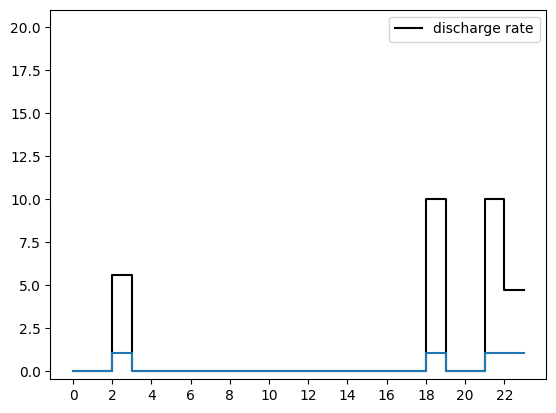

In [12]:
# plt.axhline(xmin = 0, xmax = 24, y= rated_capacity, color = 'red', linestyle = '--');
# plt.axhline(xmin = 0, xmax = 24, y= 0, color = 'red', linestyle = '--');
# plt.plot(opt_solved['soc']);
# plt.step(opt_solved.index, opt_solved['charge_energy']*charging_eff, color = 'black', label = 'charge energy');
plt.step(opt_solved.index, opt_solved['discharge_energy']/discharging_eff, color = 'black', label = 'discharge rate');
# plt.step(opt_solved.index, hourly_price, color = 'blue', label = 'price', linestyle = '-.')
plt.step(opt_solved.index, opt_solved['disch_state'])
#Price thresholds
# plt.axhline(disch_min_threshold, color = 'red', linestyle = '--', label = 'Discharge price threshold');
# plt.axhline(ch_max_threshold, color = 'red', linestyle = '--', label = 'Charge price threshold')
 
plt.xticks(np.arange(0, 24, 2));
plt.ylim([-0.5, 21]);
plt.legend();

In [221]:
opt_solved[(opt_solved.ch_state !=0)&(opt_solved.charge_energy == 0)]
# opt_solved[(opt_solved.ch_state ==0)&(opt_solved.charge_energy != 0)]
# opt_solved[(opt_solved.ch_state ==0)&(opt_solved.charge != 0)]

,ch_state,disch_state,charge_energy,discharge_energy,soc,price


In [166]:
# opt_solved.ch_state + opt_solved.disch_state

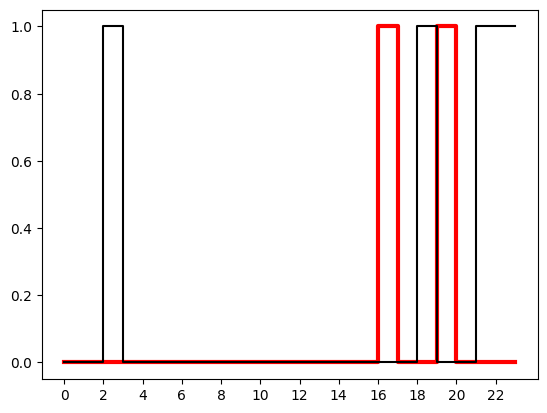

In [13]:
plt.step(opt_solved.index, opt_solved['ch_state'], color = 'red', linewidth = 3);
plt.step(opt_solved.index, opt_solved['disch_state'], color = 'black');
plt.xticks(np.arange(0, 24, 2));

🔁 What each variable means:
disch_state[t]:
This is the actual decision variable that indicates whether you are discharging at time t. It is binary (0 or 1), and used in optimization to calculate revenues, power flow, energy balance, etc.

disch_allowed[t]:
This is a logical gating variable. It's used to limit when discharging is permitted (e.g., only when price > threshold). It’s a constraint aid, not a decision you’re optimizing for directly.

disch_control constraint:
Ensures that disch_state[t] <= disch_allowed[t]. Again, this is enforcing logic, not something you include in the objective.

🔍 Metrics Used to Compare:
- Total profit / cost savings
### Utilization efficiency
How effectively the battery’s capacity is being used. You're measuring how much of the available energy throughput is being utilized compared to its maximum potential.

$$\text{Utilization Efficiency} (\%) =  \frac{\text{Total Energy Throughput}}{\text{Maximum Possible Throughput}}×100$$
**Considerations:**
- You might include efficiency losses (round-trip).
- Cap throughput to avoid over-cycling if degradation is modeled.
- If battery sat idle despite price opportunities, utilization will be low.

### Battery cycling count (degradation)

### SoC compliance


### Risk-adjusted return (e.g., Sharpe Ratio)
The Sharpe ratio below 1 is considered bad, but usually any sharpe ratio greater than 1 is considered acceptable to good by investors. A ratio higher than 2 is rated as very good and 3 is considered excellent.

In [ ]:
throughput = sum(charge_energy[t] + discharge_energy[t] for t in T)
max_possible = 2 * max_energy_per_step * len(T)  # charge + discharge at max every step

utilization_eff = 100 * throughput / max_possible
